In [1]:
import warnings

warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
from tab_transformer_pytorch import TabTransformer
import scipy.stats as st
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler, OneHotEncoder
from imblearn import over_sampling as osam, under_sampling as usam, combine as cbsam
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything()  

In [3]:
df = pd.read_csv('./impute_set/imp3.csv')

In [4]:
class CustomDataset(Dataset):
    def __init__(self, x, y, cat_col, numeric_col):
        self.X_cat = np.array(x[cat_col]).astype(np.int32)
        self.X_num = np.array(x[numeric_col]).astype(np.float32)
        self.y = np.array(y).astype(np.float32)
        
    def __len__(self):
        return len(self.X_cat)
    
    def __getitem__(self, idx):
        X_cat = torch.from_numpy(self.X_cat[idx])
        X_num = torch.from_numpy(self.X_num[idx])
        y = torch.from_numpy(self.y[idx])
        return X_cat, X_num, y


def preprocessing(df, numeric='standard', category='label'):
    X = df.drop('BS3_1', axis=1)
    y = df[['BS3_1']]
    numeric_col = [
        'FEV1', 'FEV1FVC', 'age', 'BS6_3', 'BS6_2_1', 'BD1',
        '건강문해력', 'Total_slp_wk', 'EQ_5D', 'BE3_31', 'BE5_1', '질환유병기간'
    ]
    cat_col = []
    for col in X.columns:
        if col not in numeric_col:
            cat_col.append(col)

    df_num, df_cat = X[numeric_col], X[cat_col]
    if numeric == 'minmax':
        n_pre = MinMaxScaler()
    else:
        n_pre = StandardScaler()
    df_num = pd.DataFrame(n_pre.fit_transform(df_num), columns=df_num.columns)

    if category == 'label':
        c_pre = OrdinalEncoder()
        df_cat = pd.DataFrame(c_pre.fit_transform(df_cat), columns=df_cat.columns)
    else:
        c_pre = OneHotEncoder(sparse_output=False)
        df_cat = pd.DataFrame(c_pre.fit_transform(df_cat))

    X = pd.concat([df_num, df_cat], axis=1)
    uniques = []
    for col in cat_col:
        uniques.append(len(X[col].unique()))

    return X, y, uniques, numeric_col, cat_col


def test_with_imputations(train_loader, test_loader, train_X, test_y, numeric_col, uniques):
    ppreds, ttrues = None, None
    combined_array = np.column_stack((train_X[numeric_col].mean().values, train_X[numeric_col].std().values))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_negatives = (test_y == 0).sum()
    num_positives = (test_y == 1).sum()
    class_weights = torch.tensor(num_negatives / num_positives, dtype=torch.float32).to(device)    
    model = TabTransformer(
        categories=tuple(uniques),
        num_continuous=len(numeric_col),
        dim=36,dim_out=1,depth=4,heads=5,attn_dropout=0.39153463752779954,ff_dropout=0.39153463752779954,mlp_hidden_mults=(4,2),
        mlp_act=nn.LeakyReLU(inplace=True),
        continuous_mean_std=torch.tensor(combined_array, dtype=torch.float32)
    )
    model = model.to(device)
    optim = Adam(model.parameters(), lr=.0001)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    best_f1 = 0.0
    best_epoch = 0
    epochs = 50
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for x_cat, x_num, yy in train_loader:
            optim.zero_grad()
            x_cat, x_num, yy = x_cat.to(device), x_num.to(device), yy.to(device)
            preds = model(x_cat, x_num)
            loss = criterion(preds.squeeze(), yy.squeeze())
            loss.backward()
            optim.step()
            running_loss += loss.item()
        # print(f'{epoch+1} Epoch | Loss: {running_loss/len(train_loader):.4f}')

        model.eval()
        val_loss = 0.0
        correct = 0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for x_cat, x_num, yy in test_loader:
                x_cat, x_num, yy = x_cat.to(device), x_num.to(device), yy.to(device)
                preds = model(x_cat, x_num)
                val_loss += criterion(preds.squeeze(), yy.squeeze()).item()
                yy = yy.detach().cpu().numpy().squeeze()
                preds = torch.sigmoid(preds).detach().cpu().numpy().squeeze()
                pred_labels = np.where(preds>=.5, 1, 0)
                correct += (pred_labels == yy).sum().item()
                
                val_preds.extend(pred_labels.tolist())
                val_targets.extend(yy.tolist())
        val_loss /= len(test_loader)
        val_f1 = f1_score(val_targets, val_preds, average='macro')
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch+1
            ppreds = val_preds
            ttrues = val_targets
            torch.save(model.state_dict(), 'bestTabTransformer.pth')
            
    print(f'Best Epoch: {best_epoch} | Best F1 : {best_f1:.4f}')  
    return best_f1, ppreds, ttrues


def test_with_fold(df, numeric='standard', category='label', over=False, method=None, n_folds=3):
    f1s = []
    pppreds = []
    tttrues = []
    X, y, uniques, numeric_col, cat_col = preprocessing(df, numeric, category)
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    # rskf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    for train_idx, test_idx in rskf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]        

        if over:
            if method == 'SMOTE':
                sampler = osam.SMOTE(random_state=42)
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            elif method == 'ADASYN':
                sampler = osam.ADASYN(random_state=42)
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            elif method == 'TOMEK':
                sampler = usam.TomekLinks()
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            elif method == 'SMOTETomek':
                sampler = cbsam.SMOTETomek(random_state=42)
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            else:
                raise NotImplementedError
            
        # print(f'Train data shape: {X_train.shape, y_train.shape}')
        # print(f'Train label: {y_train.value_counts()}')

        train_set = CustomDataset(X_train, y_train, cat_col, numeric_col)
        test_set = CustomDataset(X_test, y_test, cat_col, numeric_col)
        g = torch.Generator()
        g.manual_seed(42)
        train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, generator=g)
        test_loader = DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=True, generator=g)

        f1_value, ppreds, ttrues = test_with_imputations(
            train_loader, test_loader, X_train, y_test, numeric_col, uniques
        )
        f1s.append(f1_value)
        pppreds += ppreds
        tttrues += ttrues

    return f1s, pppreds, tttrues


def get_cv_results(f1s:list):
    f1s = np.array(f1s)
    mean_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    ci95 = st.t.interval(.95, df=len(f1s)-1, loc=mean_f1, scale=std_f1/np.sqrt(len(f1s)))
    return mean_f1, std_f1, ci95


def bootstrap_ci(data, n_boot=1000, ci=95):
    boot_means = []
    for _ in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_means.append(np.mean(sample))
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return np.mean(data), np.std(data), (lower, upper)

In [5]:
f1s, ppreds, ttrues = test_with_fold(df, over=False, method=None, n_folds=5)
mean_f1, std_f1, ci95 = get_cv_results(f1s)
# print(f1s)
print(f'CV Results: Mean {mean_f1:.2f} | Std {std_f1:.2f} | CI95% {ci95[0]:.2f}~{ci95[1]:.2f}')

_, _, bci95 = bootstrap_ci(f1s)
print(f'Bootstrap CI95% {bci95[0]:.2f}~{bci95[1]:.2f}')

Best Epoch: 9 | Best F1 : 0.8111
Best Epoch: 4 | Best F1 : 0.7869
Best Epoch: 3 | Best F1 : 0.7638
Best Epoch: 28 | Best F1 : 0.6500
Best Epoch: 1 | Best F1 : 0.7843
Best Epoch: 10 | Best F1 : 0.7843
Best Epoch: 5 | Best F1 : 0.8039
Best Epoch: 39 | Best F1 : 0.8478
Best Epoch: 2 | Best F1 : 0.7017
Best Epoch: 12 | Best F1 : 0.7935
Best Epoch: 10 | Best F1 : 0.8382
Best Epoch: 4 | Best F1 : 0.6359
Best Epoch: 11 | Best F1 : 0.7450
Best Epoch: 5 | Best F1 : 0.8179
Best Epoch: 13 | Best F1 : 0.7975
CV Results: Mean 0.77 | Std 0.06 | CI95% 0.74~0.80
Bootstrap CI95% 0.74~0.80


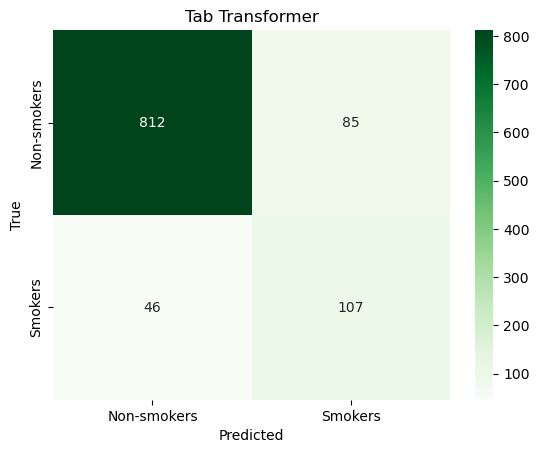

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.title('Tab Transformer')
sns.heatmap(
    confusion_matrix(ttrues, ppreds), annot=True, fmt='.0f', 
    xticklabels=['Non-smokers', 'Smokers'],
    yticklabels=['Non-smokers', 'Smokers'],
    cmap='Greens'
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()